In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [8]:
def load_image_paths_and_labels(data_dir):
    image_paths = []
    labels = []
    
    for class_name in ['DeepFake', 'Real']:
        class_dir = os.path.join(data_dir, class_name)
        for fname in os.listdir(class_dir):
            if fname.endswith('.jpg') or fname.endswith('.png'):
                image_paths.append(os.path.join(class_dir, fname))
                labels.append(0 if class_name == 'DeepFake' else 1)
    
    return image_paths, labels

In [9]:
class ImageDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for img_path in batch_image_paths:
            img = image.load_img(img_path, target_size=self.target_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)  
            images.append(img_array)
        
        return np.array(images), np.array(batch_labels)

In [10]:
train_dir = 'Dataset/Train/Preprocessed/'
batch_size = 32

image_paths, labels = load_image_paths_and_labels(train_dir)
labels = np.array(labels)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_generator = ImageDataGenerator(train_paths, train_labels, batch_size)
val_generator = ImageDataGenerator(val_paths, val_labels, batch_size)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-3]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(126, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=x)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,310,589 (188.10 MB)

 Trainable params: 25,726,973 (98.14 MB)

 Non-trainable params: 23,583,616 (89.96 MB)

In [ ]:
history1 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20


c:\Users\plati\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.5625 - loss: 1.0340 - val_accuracy: 0.6844 - val_loss: 0.5986
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 677s 1s/step - accuracy: 0.6693 - loss: 0.6223 - val_accuracy: 0.7073 - val_loss: 0.5556
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.7069 - loss: 0.5613 - val_accuracy: 0.7134 - val_loss: 0.5380
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 672s 1s/step - accuracy: 0.7219 - loss: 0.5410 - val_accuracy: 0.7173 - val_loss: 0.5266
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - accuracy: 0.7259 - loss: 0.5289 - val_accuracy: 0.7302 - val_loss: 0.5121
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.7314 - loss: 0.5171 - val_accuracy: 0.7424 - val_loss: 0.5023
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 676s 1s/step - accuracy: 0.7403 - loss: 0.5047 - val_accuracy: 0.7390 - val_loss: 0.5071
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 679s 1s/step - accuracy: 0.7511 - loss: 0.4914 - val_accuracy: 0.743

In [ ]:
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - accuracy: 0.8228 - loss: 0.4041 - val_accuracy: 0.8134 - val_loss: 0.4378
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 705s 1s/step - accuracy: 0.8216 - loss: 0.4070 - val_accuracy: 0.8081 - val_loss: 0.4376
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 712s 1s/step - accuracy: 0.8279 - loss: 0.3946 - val_accuracy: 0.8207 - val_loss: 0.4199
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.8308 - loss: 0.3916 - val_accuracy: 0.8222 - val_loss: 0.4130
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 709s 1s/step - accuracy: 0.8397 - loss: 0.3766 - val_accuracy: 0.8267 - val_loss: 0.4171
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.8382 - loss: 0.3841 - val_accuracy: 0.8244 - val_loss: 0.4186
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 709s 1s/step - accuracy: 0.8473 - loss: 0.3683 - val_accuracy: 0.8381 - val_loss: 0.4035
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 711s 1s/step - accuracy: 0.8495 - loss: 0.3637 - val_accu

In [ ]:
history3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 722s 1s/step - accuracy: 0.8861 - loss: 0.3017 - val_accuracy: 0.8643 - val_loss: 0.3671
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.8890 - loss: 0.3008 - val_accuracy: 0.8651 - val_loss: 0.3722
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 723s 1s/step - accuracy: 0.8861 - loss: 0.3037 - val_accuracy: 0.8733 - val_loss: 0.3616
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 722s 1s/step - accuracy: 0.8892 - loss: 0.2964 - val_accuracy: 0.8667 - val_loss: 0.3625
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 719s 1s/step - accuracy: 0.8924 - loss: 0.2930 - val_accuracy: 0.8737 - val_loss: 0.3481
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 728s 1s/step - accuracy: 0.8934 - loss: 0.2903 - val_accuracy: 0.8761 - val_loss: 0.3539
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.8970 - loss: 0.2817 - val_accuracy: 0.8729 - val_loss: 0.3524
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 798s 1s/step - accuracy: 0.8924 - loss: 0.2929 - val_accu

In [ ]:
history4 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 759s 1s/step - accuracy: 0.9095 - loss: 0.2574 - val_accuracy: 0.8960 - val_loss: 0.3182
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 757s 1s/step - accuracy: 0.9103 - loss: 0.2575 - val_accuracy: 0.8908 - val_loss: 0.3254
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.9146 - loss: 0.2509 - val_accuracy: 0.8949 - val_loss: 0.3223
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 737s 1s/step - accuracy: 0.9178 - loss: 0.2472 - val_accuracy: 0.8835 - val_loss: 0.3349
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 766s 1s/step - accuracy: 0.9155 - loss: 0.2456 - val_accuracy: 0.8984 - val_loss: 0.3179
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 777s 1s/step - accuracy: 0.9186 - loss: 0.2418 - val_accuracy: 0.8931 - val_loss: 0.3161
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.9171 - loss: 0.2448 - val_accuracy: 0.8882 - val_loss: 0.3209
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.9185 - loss: 0.2393 - val_accu

In [ ]:
history5 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.9285 - loss: 0.2192 - val_accuracy: 0.8990 - val_loss: 0.2974
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 707s 1s/step - accuracy: 0.9296 - loss: 0.2151 - val_accuracy: 0.9082 - val_loss: 0.2956
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 700s 1s/step - accuracy: 0.9318 - loss: 0.2094 - val_accuracy: 0.9111 - val_loss: 0.2866
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - accuracy: 0.9272 - loss: 0.2191 - val_accuracy: 0.9143 - val_loss: 0.2819
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.9332 - loss: 0.2107 - val_accuracy: 0.9066 - val_loss: 0.3078
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 691s 1s/step - accuracy: 0.9348 - loss: 0.2112 - val_accuracy: 0.9054 - val_loss: 0.2867
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 693s 1s/step - accuracy: 0.9360 - loss: 0.2024 - val_accuracy: 0.9068 - val_loss: 0.2933
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.9345 - loss: 0.2065 - val_accu

In [ ]:
history6 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.9403 - loss: 0.1891 - val_accuracy: 0.9135 - val_loss: 0.2781
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.9414 - loss: 0.1844 - val_accuracy: 0.9146 - val_loss: 0.2900
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.9446 - loss: 0.1824 - val_accuracy: 0.9176 - val_loss: 0.2704
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.9454 - loss: 0.1815 - val_accuracy: 0.9160 - val_loss: 0.2697
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.9417 - loss: 0.1877 - val_accuracy: 0.9096 - val_loss: 0.2791
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9454 - loss: 0.1747 - val_accuracy: 0.9135 - val_loss: 0.2781
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 731s 1s/step - accuracy: 0.9417 - loss: 0.1867 - val_accuracy: 0.9174 - val_loss: 0.2759
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9438 - loss: 0.1831 - val_accu

In [ ]:
history7 = model.fit(
    train_generator,
    validation_data=val_generator   ,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 769s 1s/step - accuracy: 0.9483 - loss: 0.1710 - val_accuracy: 0.9203 - val_loss: 0.2708
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.9515 - loss: 0.1634 - val_accuracy: 0.9101 - val_loss: 0.2933
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.9482 - loss: 0.1723 - val_accuracy: 0.9195 - val_loss: 0.2738
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 742s 1s/step - accuracy: 0.9536 - loss: 0.1587 - val_accuracy: 0.9162 - val_loss: 0.2824
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.9474 - loss: 0.1767 - val_accuracy: 0.9205 - val_loss: 0.2685
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9511 - loss: 0.1643 - val_accuracy: 0.9168 - val_loss: 0.2740
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9519 - loss: 0.1634 - val_accuracy: 0.9123 - val_loss: 0.2849
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.9525 - loss: 0.1662 - val_accu

In [ ]:
history8 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

Epoch 1/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 779s 1s/step - accuracy: 0.9547 - loss: 0.1545 - val_accuracy: 0.9260 - val_loss: 0.2629
Epoch 2/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 754s 1s/step - accuracy: 0.9558 - loss: 0.1537 - val_accuracy: 0.9231 - val_loss: 0.2769
Epoch 3/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.9589 - loss: 0.1451 - val_accuracy: 0.9188 - val_loss: 0.2919
Epoch 4/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.9510 - loss: 0.1646 - val_accuracy: 0.9219 - val_loss: 0.2756
Epoch 5/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9560 - loss: 0.1505 - val_accuracy: 0.9178 - val_loss: 0.2794
Epoch 6/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9551 - loss: 0.1543 - val_accuracy: 0.9213 - val_loss: 0.2655
Epoch 7/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 749s 1s/step - accuracy: 0.9579 - loss: 0.1463 - val_accuracy: 0.9195 - val_loss: 0.2773
Epoch 8/20
639/639 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.9559 - loss: 0.1523 - val_accu

In [ ]:
model.save('resnet50_model.h5')

In [2]:
import pickle

In [ ]:
histories = [history1, history2, history3, history4, history5, history6, history7, history8]

with open('training_histories.pkl', 'wb') as file:
    pickle.dump(histories, file)

In [ ]:
with open('training_histories.pkl', 'rb') as file:
    histories = pickle.load(file)

c:\Users\plati\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [5]:
import matplotlib.pyplot as plt

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

for history in histories:
    train_accuracies.extend(history.history['accuracy'])
    val_accuracies.extend(history.history['val_accuracy'])
    train_losses.extend(history.history['loss'])
    val_losses.extend(history.history['val_loss'])

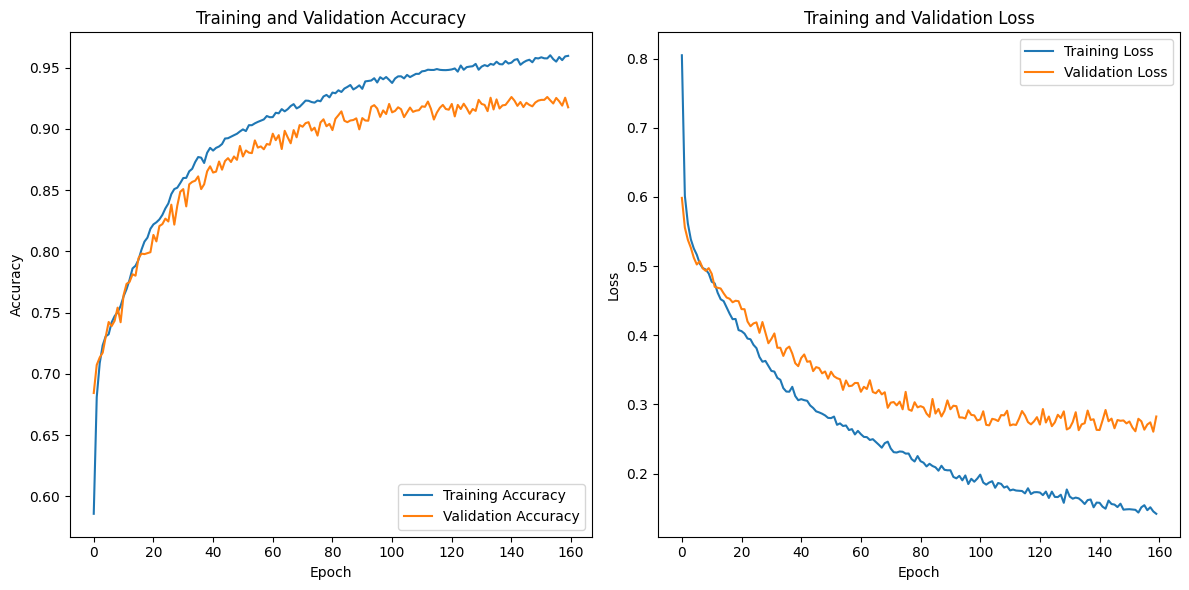

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from tensorflow.keras.models import load_model

In [5]:
model = load_model('resnet50_model.h5')

In [12]:
train_predictions = model.predict(train_generator)
train_predictions = (train_predictions > 0.5).astype(int) 
train_labels = train_labels[:len(train_predictions)]  

c:\Users\plati\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


639/639 ━━━━━━━━━━━━━━━━━━━━ 531s 829ms/step


In [13]:
conf_matrix = confusion_matrix(train_labels, train_predictions)

f1 = f1_score(train_labels, train_predictions)
precision = precision_score(train_labels, train_predictions)
recall = recall_score(train_labels, train_predictions)
classification_rep = classification_report(train_labels, train_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Confusion Matrix:
[[10676   152]
 [  344  9257]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     10828
           1       0.98      0.96      0.97      9601

    accuracy                           0.98     20429
   macro avg       0.98      0.98      0.98     20429
weighted avg       0.98      0.98      0.98     20429

F1 Score: 0.97
Precision: 0.98
Recall: 0.96


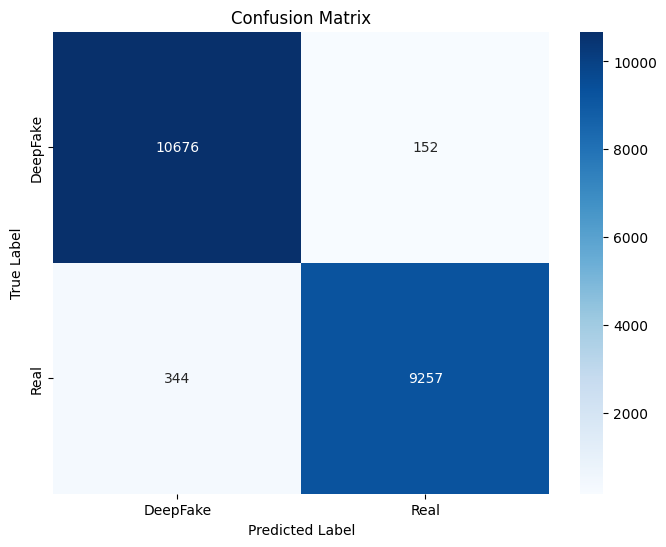

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['DeepFake', 'Real'], yticklabels=['DeepFake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [1]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
import seaborn as sns
from tensorflow.keras.models import load_model

In [2]:
model = load_model('resnet50_model.h5')

In [ ]:
class FullDatasetGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size=(224, 224)):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))
    
    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for img_path in batch_image_paths:
            img = image.load_img(img_path, target_size=self.target_size)
            img_array = image.img_to_array(img)
            img_array = preprocess_input(img_array)
            images.append(img_array)
        
        return np.array(images), np.array(batch_labels)

In [ ]:
# Directory containing the entire dataset
train_dir = 'Dataset/Train/Preprocessed/'

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(train_dir)
labels = np.array(labels)

# Initialize the data generator
batch_size = 32
full_dataset_generator = FullDatasetGenerator(image_paths, labels, batch_size)

In [ ]:
train_predictions = model.predict(full_dataset_generator)
train_predictions = (train_predictions > 0.5).astype(int) 
train_labels = train_labels[:len(train_predictions)]  

799/799 ━━━━━━━━━━━━━━━━━━━━ 674s 843ms/step


In [ ]:
conf_matrix = confusion_matrix(labels, train_predictions)

f1 = f1_score(labels, train_predictions)
precision = precision_score(labels, train_predictions)
recall = recall_score(labels, train_predictions)
classification_rep = classification_report(labels, train_predictions)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)
print(f"F1 Score: {f1:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Confusion Matrix:
[[13281   255]
 [  662 11339]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     13536
           1       0.98      0.94      0.96     12001

    accuracy                           0.96     25537
   macro avg       0.97      0.96      0.96     25537
weighted avg       0.96      0.96      0.96     25537

F1 Score: 0.96
Precision: 0.98
Recall: 0.94


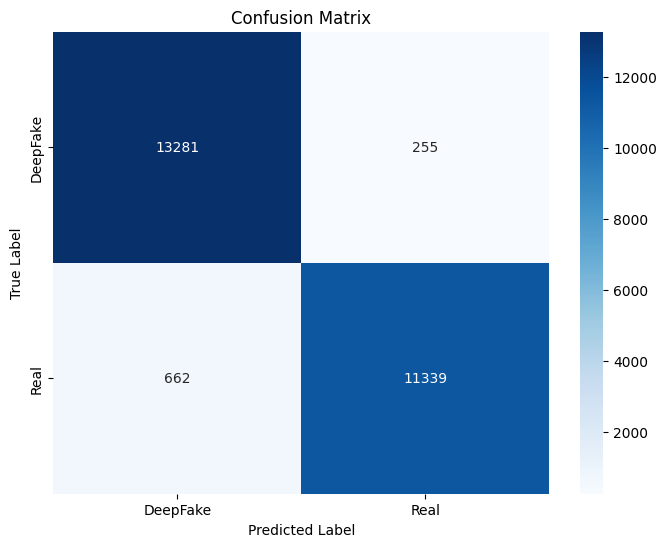

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['DeepFake', 'Real'], yticklabels=['DeepFake', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()